# Titanic - Machine Learning from Disaster

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Длина имени
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Новая фича
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Фича IsAlone от FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Удаление нулей
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Удаление нулей
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Новая фича
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
   
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Размечаем Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Размечаем titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Размечаем Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Размечаем Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Размечаем возраст
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Фичи
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


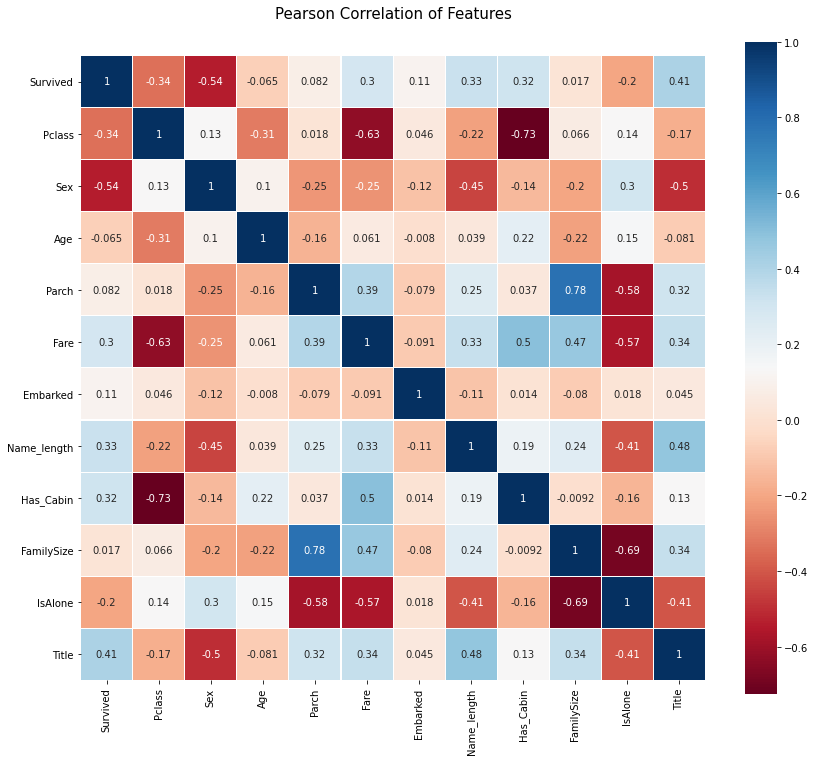

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

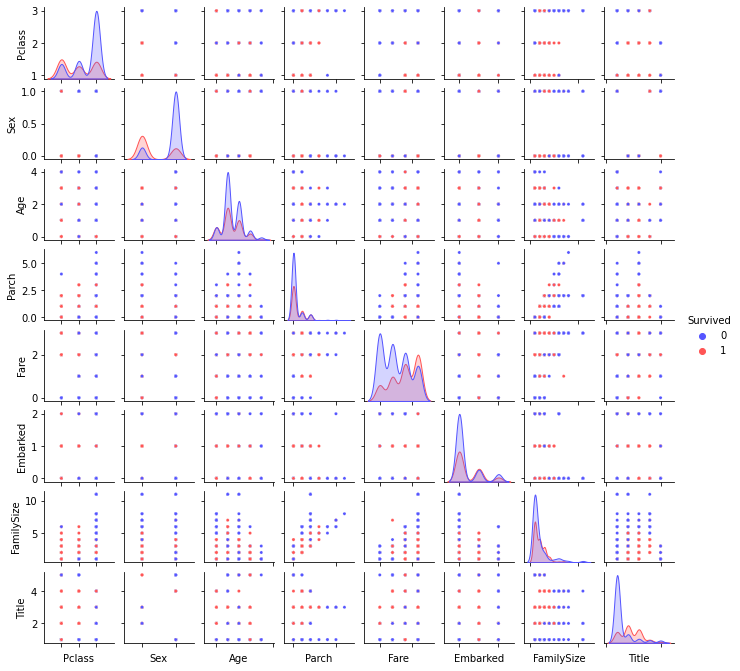

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

### Построение модели

### 1.

Построение модели при помощи алгоритмов RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

In [8]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)

In [9]:
# Делим на целевую выборку и фичи
X = train.drop(columns=['Survived']).values
Y = train[['Survived']].values

In [10]:
from sklearn.model_selection import train_test_split

X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=17)

### 2.
1. Определяем GridSearchCV для всех приведенных параметров каждого алгоритма.

2. Обучаем каждый из объектов. Выводим лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получаем предсказания на валидационных данных и выводим метрику качества, которая соответствует метрике оценки соревнования.

In [11]:
gbc = GradientBoostingClassifier(random_state=17)

gbc_grid = GridSearchCV(gbc, gbc_params, cv=skf)

gbc_model = gbc_grid.fit(X_train, Y_train)

gbc_best_params = gbc_model.best_params_
gbc_best_params

{'learning_rate': 0.1}

In [12]:
rfc = RandomForestClassifier(random_state=17)

rfc_grid = GridSearchCV(rfc, rfc_params, cv=skf)

rfc_model = rfc_grid.fit(X_train, Y_train)

rfc_best_params = rfc_model.best_params_
rfc_best_params

{'min_samples_leaf': 4, 'n_estimators': 60}

In [13]:
svc = SVC(random_state=17)

svc_grid = GridSearchCV(svc, svc_params, cv=skf)

svc_model = svc_grid.fit(X_train, Y_train)

svc_best_params = svc_model.best_params_
svc_best_params

{'C': 0.1, 'kernel': 'linear'}

In [14]:
lr = LogisticRegression(random_state=17)

lr_grid = GridSearchCV(lr, lr_params, cv=skf)

lr_model = lr_grid.fit(X_train, Y_train)

lr_best_params = lr_model.best_params_
lr_best_params

{'C': 0.5}

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
predicted_rfc = rfc_model.predict(x_test)
accuracy_rfc = accuracy_score(y_test, predicted_rfc)
accuracy_rfc

0.7666666666666667

In [17]:
predicted_gbc = gbc_model.predict(x_test)
accuracy_gbc = accuracy_score(y_test, predicted_gbc)
accuracy_gbc

0.7222222222222222

In [18]:
predicted_svc = svc_model.predict(x_test)
accuracy_svc = accuracy_score(y_test, predicted_svc)
accuracy_svc

0.8

In [19]:
predicted_lr = lr_model.predict(x_test)
accuracy_lr = accuracy_score(y_test, predicted_lr)
accuracy_lr

0.7666666666666667

### 3.
С помощью GridSearchCV и указанных ниже параметров настраиваем мета-алгоритм на мета-признаках. Матрицу метапризнаков получаям из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами.

In [20]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [21]:
# Создаем матрицу предсказаний
predictions = [predicted_rfc, predicted_gbc, predicted_svc, predicted_lr]

meta_mtrx = np.empty((x_test.shape[0], len(predictions)))        
for n, predict in enumerate(predictions):
    meta_mtrx[:, n] = predict 

In [22]:
from xgboost import XGBClassifier

meta = XGBClassifier(random_state=17)

xgb_grid = GridSearchCV(meta, xgb_params, cv=5)

## WARNING! То что ниже считается 40 минут))

In [23]:
#xgb_model = xgb_grid.fit(meta_mtrx, y_test)

## Копия результата работы GridSearch

In [24]:
xgb_best_params = {
    'eta': 0.6,
    'min_child_weight': 1,
    'n_estimators': 80,
    'subsample': 0.7000000000000001
    }

In [25]:
gbc = GradientBoostingClassifier(learning_rate=0.2, random_state=17)

rfc = RandomForestClassifier(min_samples_leaf=3, n_estimators=20, random_state=17)

svc = SVC(C=0.1, kernel='linear', random_state=17)

lr = LogisticRegression(C=0.5, random_state=17)

In [26]:
models = [gbc_model, rfc_model, svc_model, lr_model]

In [27]:
meta = XGBClassifier(eta=0.6, min_child_weight=1, n_estimators=80, subsample=0.7000000000000001, random_state=17, cv=5)

### 4.
Строим стекинг для всех моделей с наилучшими подобранными параметрами.

In [28]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [29]:
test.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1


In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

data_train = train.drop(columns='Survived').values
targets_train = train[['Survived']].values
data_test = test.values

In [31]:
meta_mtrx = np.empty((data_train.shape[0], len(models)))
        
for n, model in enumerate(models):
    meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv=5, method='predict')            
for model in models:
    model = model.fit(data_train, targets_train)   
            
meta_alg = meta.fit(meta_mtrx, targets_train)

meta_mtrx_test = np.empty((data_test.shape[0], len(models)))

for n, model in enumerate(models):
    meta_mtrx_test[:, n] = model.predict(data_test)
meta_alg_predicted = meta.predict(meta_mtrx_test)

[03:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { cv } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
test_for_id = pd.read_csv('test.csv')

In [33]:
PassengerId = test_for_id[['PassengerId']].values[:,0]

### 5.
Файл для Kaggle.

In [34]:
def write_to_submission_file(meta_predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, meta_predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [35]:
write_to_submission_file(meta_predictions=meta_alg_predicted, PassengerID=PassengerId)

Точность на тестовой выборке 76%

### 6. TF Neural net

In [36]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17)

In [37]:
X_train[0].shape

(11,)

In [38]:
x_test.shape

(179, 11)

In [39]:
X_train = X_train / 1.0
x_test = x_test / 1.0

In [40]:
import tensorflow as tf
from tensorflow.keras import regularizers
print(tf.__version__)

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

2.1.0


In [41]:
def show_progress(history: dict):
    """Функция по acc и loss"""
    
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["accuracy"],label='train accuracy')
    plt.plot(history["val_accuracy"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [42]:
# Путь для записи прогресса и лучших параметров модели
path = Path("data/model_1")
path.mkdir(exist_ok=True, parents=True)
assert path.exists()

cpt_filename = "best_checkpoint.hdf5"  
cpt_path =str(path / cpt_filename)

In [49]:
# Модель 1
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(12, input_shape=X_train[0].shape, activation='sigmoid', 
                                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

model.add(tf.keras.layers.Dense(400, activation='sigmoid', 
                                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

model.add(tf.keras.layers.Dense(300, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) 

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) 
history = model.fit(X_train, Y_train, validation_data=(x_test, y_test), batch_size=2, epochs=40, verbose=0, shuffle=False, callbacks=[checkpoint])

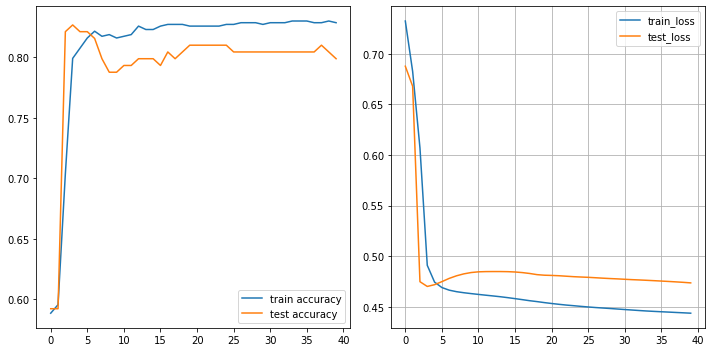

In [44]:
show_progress(history.history)

In [45]:
# Accuracy на валидации лучшей модели
restored_model = tf.keras.models.load_model(cpt_path)
loss, acc = restored_model.evaluate(x_test, y_test)
print(f"Accuracy of restored model {acc*100 :.2f}%")

179/179 [==============================] - 0s 884us/sample - loss: 0.4701 - accuracy: 0.8268
Accuracy of restored model 82.68%


In [46]:
test.values

array([[3, 1, 2, ..., 1, 1, 1],
       [3, 0, 2, ..., 2, 0, 3],
       [2, 1, 3, ..., 1, 1, 1],
       ...,
       [3, 1, 2, ..., 1, 1, 1],
       [3, 1, 1, ..., 1, 1, 1],
       [3, 1, 2, ..., 3, 0, 4]], dtype=int64)

In [47]:
predicted = restored_model.predict_classes(test.values)
write_to_submission_file(meta_predictions=predicted.ravel(), PassengerID=PassengerId)